In [1]:
from keras.models import Sequential 
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model
from keras.datasets import mnist
from keras import backend as k
from keras.layers import Lambda
from tensorflow.keras.metrics import binary_crossentropy
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [2]:
data = pd.read_csv('Data.csv')

X = data.drop(['label','Label'], axis = 1)
y = data['label']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [4]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.values.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.values.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(X_train.shape)
print(X_test.shape)

(17132, 784)
(4284, 784)


In [5]:
def sampling(args):
    mu, log_var = args
    eps = k.random_normal(shape=(keras.backend.shape(mu)[0], latent_dim), mean=0., stddev=1.0)
    return mu + k.exp(log_var) * eps

In [6]:
batch_size, n_epoch = 100, 150
latent_dim = 2

input_data = Input(shape=(X_train[0].shape))
X = Dense(200, activation='relu')(input_data)
X= Dense(100, activation='relu')(X)
X = Dense(30, activation='relu')(X)

mu = Dense(latent_dim)(X)
log_var = Dense(latent_dim)(X)

z = Lambda(sampling)([mu, log_var])

encoder = Model(input_data, z, name='Encoder')
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 200)          157000      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          20100       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 30)           3030        ['dense_1[0][0]']                
                                                                                            

In [7]:
z_decoder1 = Dense(30, activation='relu')
z_decoder2 = Dense(100, activation='relu')
z_decoder3 = Dense(200, activation='relu')
y_decoder = Dense((X_train[0].shape[0]), activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
z_decoded = z_decoder3(z_decoded)
y = y_decoder(z_decoded)

decoder = Model(z, y, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 30)                90        
                                                                 
 dense_6 (Dense)             (None, 100)               3100      
                                                                 
 dense_7 (Dense)             (None, 200)               20200     
                                                                 
 dense_8 (Dense)             (None, 784)               157584    
                                                                 
Total params: 180,974
Trainable params: 180,974
Non-trainable params: 0
_________________________________________________________________


In [8]:
reconstruction_loss = binary_crossentropy(input_data, y) * X_train[0].shape
kl_loss = 0.5 * k.sum(k.square(mu) + k.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

vae = Model(input_data, y, name='VAE')
vae.add_loss(vae_loss)

vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 200)          157000      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          20100       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 30)           3030        ['dense_1[0][0]']                
                                                                                                

In [9]:
vae.compile(optimizer='rmsprop')
history = vae.fit(X_train, shuffle=True, epochs=14, batch_size=batch_size, validation_data=(X_train, None), verbose=1)

Epoch 1/14
172/172 [==============================] - 5s 16ms/step - loss: 222.9244 - val_loss: 192.0228
Epoch 2/14
172/172 [==============================] - 2s 13ms/step - loss: 180.8060 - val_loss: 169.0263
Epoch 3/14
172/172 [==============================] - 2s 14ms/step - loss: 164.6885 - val_loss: 159.2755
Epoch 4/14
172/172 [==============================] - 2s 13ms/step - loss: 157.9210 - val_loss: 154.8804
Epoch 5/14
172/172 [==============================] - 2s 13ms/step - loss: 153.8583 - val_loss: 150.9643
Epoch 6/14
172/172 [==============================] - 2s 12ms/step - loss: 150.6273 - val_loss: 148.3514
Epoch 7/14
172/172 [==============================] - 2s 13ms/step - loss: 148.1842 - val_loss: 146.1134
Epoch 8/14
172/172 [==============================] - 2s 14ms/step - loss: 146.1612 - val_loss: 144.5202
Epoch 9/14
172/172 [==============================] - 2s 14ms/step - loss: 144.3284 - val_loss: 142.7024
Epoch 10/14
172/172 [==============================] - 

17/17 [==============================] - 0s 4ms/step


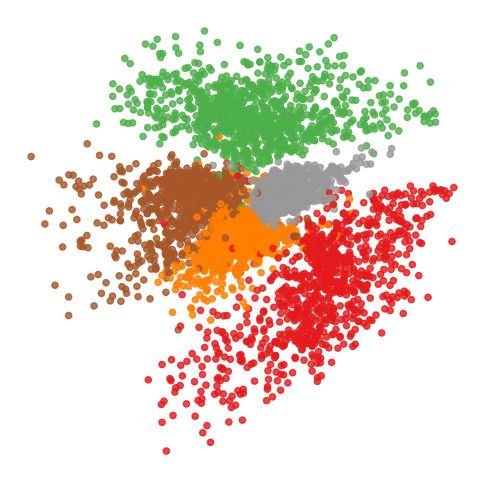

In [10]:
x_te_latent = encoder.predict(X_test, batch_size=256)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], s=20, alpha=0.8, cmap='Set1', c=y_test[0:X_test.shape[0]])
plt.axis('off')   
plt.show()

In [11]:
encoder.trainable = False

In [12]:
cls1 = Dense(3, activation='relu')
cls2 = Dense(4, activation='relu')
cls3 = Dense(5, activation='softmax')

CL1 = cls1(z)
CL2 = cls2(CL1)
CL3 = cls3(CL2)

In [13]:
vaec = Model(input_data, CL3, name='VAEClassifier')
vaec.summary()

Model: "VAEClassifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 200)          157000      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          20100       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 30)           3030        ['dense_1[0][0]']                
                                                                                      

In [14]:
lbl = LabelEncoder()
y_train = lbl.fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = lbl.fit_transform(y_test)
y_test = to_categorical(y_test)

In [15]:
from tensorflow.keras.optimizers import Adam
opt = Adam()

# Configuring the model for training
vaec.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
history_vaec = vaec.fit(X_train,y_train,epochs=50,batch_size=5,validation_split=0.2)

Epoch 1/50
2741/2741 [==============================] - 10s 3ms/step - loss: 1.0391 - accuracy: 0.5785 - val_loss: 0.6396 - val_accuracy: 0.7362
Epoch 2/50
2741/2741 [==============================] - 9s 3ms/step - loss: 0.5464 - accuracy: 0.8001 - val_loss: 0.4363 - val_accuracy: 0.8903
Epoch 3/50
2741/2741 [==============================] - 9s 3ms/step - loss: 0.3647 - accuracy: 0.9074 - val_loss: 0.3015 - val_accuracy: 0.9215
Epoch 4/50
2741/2741 [==============================] - 9s 3ms/step - loss: 0.2842 - accuracy: 0.9282 - val_loss: 0.2586 - val_accuracy: 0.9390
Epoch 5/50
2741/2741 [==============================] - 9s 3ms/step - loss: 0.2587 - accuracy: 0.9383 - val_loss: 0.2408 - val_accuracy: 0.9413
Epoch 6/50
2741/2741 [==============================] - 9s 3ms/step - loss: 0.2466 - accuracy: 0.9388 - val_loss: 0.2376 - val_accuracy: 0.9425
Epoch 7/50
2741/2741 [==============================] - 9s 3ms/step - loss: 0.2415 - accuracy: 0.9406 - val_loss: 0.2322 - val_accuracy

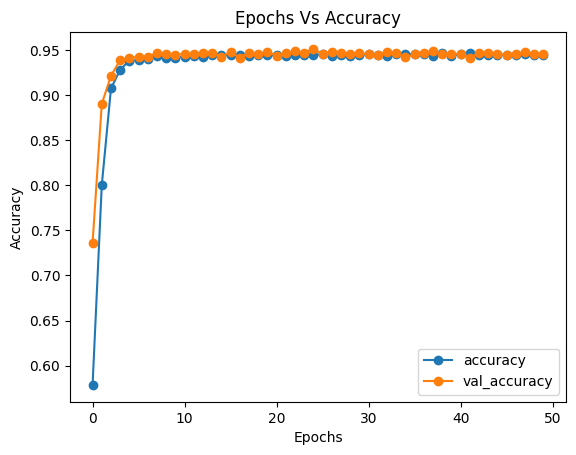

In [17]:
plt.plot(np.array((history_vaec.history)['accuracy']),'-o')
plt.plot(np.array((history_vaec.history)['val_accuracy']),'-o')
plt.title("Epochs Vs Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['accuracy','val_accuracy'])
plt.show()

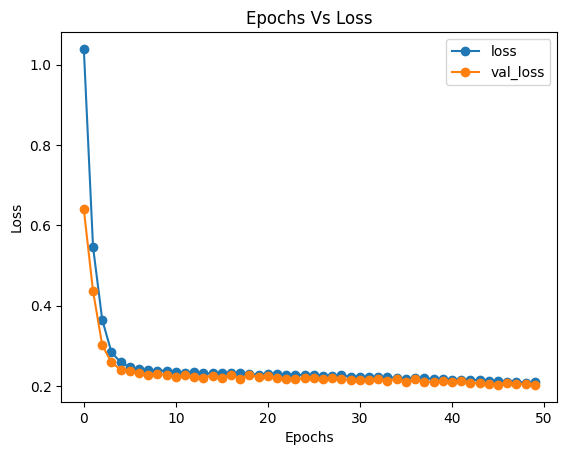

In [18]:
plt.plot(np.array((history_vaec.history)['loss']),'-o')
plt.plot(np.array((history_vaec.history)['val_loss']),'-o')
plt.title("Epochs Vs Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['loss','val_loss'])
plt.show()

In [19]:
predictions = vaec.predict(X_test)

134/134 [==============================] - 0s 2ms/step


In [20]:
test_loss, test_acc = vaec.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

134/134 [==============================] - 0s 3ms/step - loss: 0.2154 - accuracy: 0.9472
Test loss: 0.21540191769599915
Test accuracy: 0.9472455382347107


In [21]:
y_pred = [np.argmax(np.round(predictions[i])) for i in range(len(X_test))]
y_true = [np.argmax(y_test[i]) for i in range(len(X_test))]

In [22]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.BuPu):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

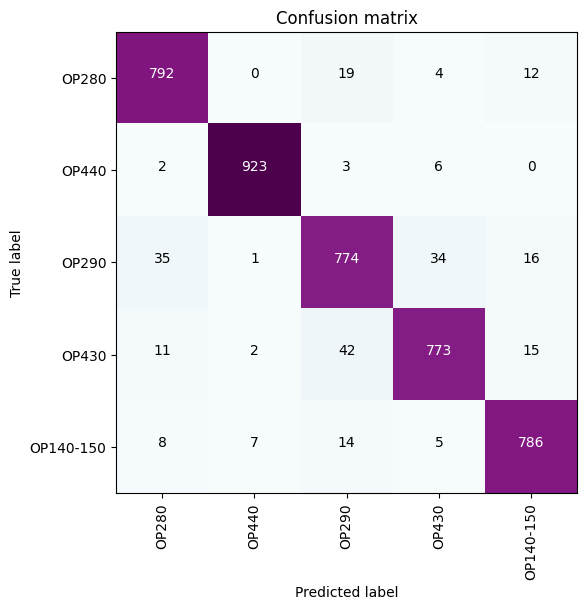

In [23]:
cm = confusion_matrix(y_true,y_pred)
cm_plot = plot_confusion_matrix(cm,classes=[str(i) for i in set(data['Label'])])